# Capstone Project: Toronto Restaurant Market Opportunity Analysis

We use the neighborhood listings and the FourSquare venue listings from prior projects to obtain a picture of which and how many restaurants of different types can be found in the different neighborhoods of Toronto. We then compare the frequencies of different types of restaurants across neighborhoods to find out where there may be fewer restaurants than the market can support, which we can recommend as opportunities to open new restaurants of different types.

In [1]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
import pandas as pd
import requests
import json

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library
import geopy.distance

pd.options.display.max_rows = None
pd.options.display.max_columns = None

## Get Toronto Neighborhood Data

Replicate the Toronto Neighborhood analysis to get the DataFrame of neighborhoods and lat/lng coordinates

In [3]:
all_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]
all_df = all_df[all_df.Borough != 'Not assigned'].reset_index(drop=True)
all_df['Neighborhood'] = all_df.Neighborhood.str.replace(' / ', ', ')
codes_df = pd.read_csv('http://cocl.us/Geospatial_data')
all_df.rename(columns={'Postal code': 'Postal Code'}, inplace=True)
merged_df = pd.merge(all_df, codes_df, on='Postal Code')
toronto_df = merged_df.loc[merged_df.Borough.str.contains('Toronto'), :]
toronto_df

Postal Code           Borough  \
2           M5A  Downtown Toronto   
4           M7A  Downtown Toronto   
9           M5B  Downtown Toronto   
15          M5C  Downtown Toronto   
19          M4E      East Toronto   
20          M5E  Downtown Toronto   
24          M5G  Downtown Toronto   
25          M6G  Downtown Toronto   
30          M5H  Downtown Toronto   
31          M6H      West Toronto   
36          M5J  Downtown Toronto   
37          M6J      West Toronto   
41          M4K      East Toronto   
42          M5K  Downtown Toronto   
43          M6K      West Toronto   
47          M4L      East Toronto   
48          M5L  Downtown Toronto   
54          M4M      East Toronto   
61          M4N   Central Toronto   
62          M5N   Central Toronto   
67          M4P   Central Toronto   
68          M5P   Central Toronto   
69          M6P      West Toronto   
73          M4R   Central Toronto   
74          M5R   Central Toronto   
75          M6R      West Toronto   
79          M4S   Central Toronto   
80          M5S  Downtown Toronto   
81          M6S      West Toronto   
83          M4T   Central Toronto   
84          M5T  Downtown Toronto   
86          M4V   Central Toronto   
87          M5V  Downtown Toronto   
91          M4W  Downtown Toronto   
92          M5W  Downtown Toronto   
96          M4X  Downtown Toronto   
97          M5X  Downtown Toronto   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   

                                          Neighborhood   Latitude  Longitude  
2                            Regent Park, Harbourfront  43.654260 -79.360636  
4          Queen's Park, Ontario Provincial Government  43.662301 -79.389494  
9                             Garden District, Ryerson  43.657162 -79.378937  
15                                      St. James Town  43.651494 -79.375418  
19                                         The Beaches  43.676357 -79.293031  
20                                         Berczy Park  43.644771 -79.373306  
24                                  Central Bay Street  43.657952 -79.387383  
25                                            Christie  43.669542 -79.422564  
30                            Richmond, Adelaide, King  43.650571 -79.384568  
31                        Dufferin, Dovercourt Village  43.669005 -79.442259  
36   Harbourfront East, Union Station, Toronto Islands  43.640816 -79.381752  
37                            Little Portugal, Trinity  43.647927 -79.419750  
41                        The Danforth West, Riverdale  43.679557 -79.352188  
42            Toronto Dominion Centre, Design Exchange  43.647177 -79.381576  
43        Brockton, Parkdale Village, Exhibition Place  43.636847 -79.428191  
47                      India Bazaar, The Beaches West  43.668999 -79.315572  
48                      Commerce Court, Victoria Hotel  43.648198 -79.379817  
54                                     Studio District  43.659526 -79.340923  
61                                       Lawrence Park  43.728020 -79.388790  
62                                            Roselawn  43.711695 -79.416936  
67                                    Davisville North  43.712751 -79.390197  
68                            Forest Hill North & West  43.696948 -79.411307  
69                       High Park, The Junction South  43.661608 -79.464763  
73                                  North Toronto West  43.715383 -79.405678  
74                 The Annex, North Midtown, Yorkville  43.672710 -79.405678  
75                              Parkdale, Roncesvalles  43.648960 -79.456325  
79                                          Davisville  43.704324 -79.388790  
80                      University of Toronto, Harbord  43.662696 -79.400049  
81                                  Runnymede, Swansea  43.651571 -79.484450  
83                         Moore Park, Summerhill East  43.689574 -79.383160  
84           Kensington Market, Chinatown, Grange Park  43.653206 -79.4000

Setup Foursquare client

In [4]:
CLIENT_ID = 'OYNS3XUIYOI03MTSQQP1NFHOOL2AB4QJFTU3HMCIZ12RFY1L' # your Foursquare ID
CLIENT_SECRET = '1XQM1SGIJB2CWEY2AGRHRZ53NBX45E4MGTYE1UGXPIWJDNWJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

def get_foursquare_neighborhood(neighborhood_latitude, neighborhood_longitude, radius=500, limit=100):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius, 
        limit)
    return requests.get(url).json()

COLUMNS_TO_SELECT = [
    'Postal Code',
    'headerLocation',
    'venue.location.lat',
    'venue.location.lng',
    # 'venue.location.postalCode',
    'venue.id',
    'venue.name',
    'category'
]

def get_foursquare_neighborhood_df(postal_code, neighborhood_latitude, neighborhood_longitude, radius=500, limit=100):
    ret_json = get_foursquare_neighborhood(neighborhood_latitude, neighborhood_longitude, radius=500, limit=100)
    ret_df = json_normalize(ret_json['response']['groups'][0]['items'])
    ret_df['category'] = ret_df['venue.categories'].apply(lambda x: x[0]['shortName'])
    ret_df['Postal Code'] = postal_code
    ret_df['headerLocation'] = ret_json['response']['headerLocation']
    
    suggested_bounds_df = json_normalize(ret_json['response']['suggestedBounds'])
    for col in suggested_bounds_df.columns:
        ret_df.loc[:, col] = suggested_bounds_df.iloc[0][col]

    return ret_df[COLUMNS_TO_SELECT + suggested_bounds_df.columns.tolist()]

In [5]:
venues_df = pd.concat([get_foursquare_neighborhood_df(r['Postal Code'], r.Latitude, r.Longitude) for _, r in toronto_df.iterrows()])
venues_df

Postal Code         headerLocation  venue.location.lat  venue.location.lng  \
0          M5A               Corktown           43.653447          -79.362017   
1          M5A               Corktown           43.653559          -79.361809   
2          M5A               Corktown           43.653249          -79.358008   
3          M5A               Corktown           43.654735          -79.359874   
4          M5A               Corktown           43.653947          -79.361149   
5          M5A               Corktown           43.656369          -79.356980   
6          M5A               Corktown           43.655618          -79.356211   
7          M5A               Corktown           43.655675          -79.364503   
8          M5A               Corktown           43.650244          -79.359323   
9          M5A               Corktown           43.656919          -79.358967   
10         M5A               Corktown           43.650075          -79.361832   
11         M5A               Corktown           43.650622          -79.358127   
12         M5A               Corktown           43.651900          -79.365609   
13         M5A               Corktown           43.650067          -79.360723   
14         M5A               Corktown           43.649963          -79.361442   
15         M5A               Corktown           43.652756          -79.364753   
16         M5A               Corktown           43.658135          -79.359515   
17         M5A               Corktown           43.650825          -79.357593   
18         M5A               Corktown           43.651613          -79.364917   
19         M5A               Corktown           43.653313          -79.359725   
20         M5A               Corktown           43.650574          -79.359539   
21         M5A               Corktown           43.650565          -79.357843   
22         M5A               Corktown           43.655764          -79.354806   
23         M5A               Corktown           43.656739          -79.356503   
24         M5A               Corktown           43.650264          -79.362195   
25         M5A               Corktown           43.654959          -79.365657   
26         M5A               Corktown           43.650632          -79.358709   
27         M5A               Corktown           43.655123          -79.365873   
28         M5A               Corktown           43.649970          -79.358849   
29         M5A               Corktown           43.653081          -79.357078   
30         M5A               Corktown           43.655515          -79.364955   
31         M5A               Corktown           43.650353          -79.358489   
32         M5A               Corktown           43.650102          -79.360440   
33         M5A               Corktown           43.649970          -79.360153   
34         M5A               Corktown           43.649896          -79.359436   
35         M5A               Corktown           43.650780          -79.357615   
36         M5A               Corktown           43.650022          -79.361222   
37         M5A               Corktown           43.649892          -79.361005   
38         M5A               Corktown           43.653634          -79.354662   
39         M5A               Corktown           43.657046          -79.359667   
40         M5A               Corktown           43.652780          -79.356336   
41         M5A               Corktown           43.657773          -79.357463   
42         M5A               Corktown           43.656821          -79.358970   
43         M5A               Corktown           43.653040          -79.357040   
44         M5A               Corktown           43.656265          -79.357119   
45         M5A               Corktown           43.650495          -79.357538   
0          M7A    Bay Street Corridor           43.663946          -79.392180   
1          M7A    Bay Street Corridor           43.660391          -79.387664   
2          M7A    Bay Street Corri

In [6]:
combined_df = pd.merge(toronto_df, venues_df, on='Postal Code')
combined_df

Postal Code           Borough  \
0            M5A  Downtown Toronto   
1            M5A  Downtown Toronto   
2            M5A  Downtown Toronto   
3            M5A  Downtown Toronto   
4            M5A  Downtown Toronto   
5            M5A  Downtown Toronto   
6            M5A  Downtown Toronto   
7            M5A  Downtown Toronto   
8            M5A  Downtown Toronto   
9            M5A  Downtown Toronto   
10           M5A  Downtown Toronto   
11           M5A  Downtown Toronto   
12           M5A  Downtown Toronto   
13           M5A  Downtown Toronto   
14           M5A  Downtown Toronto   
15           M5A  Downtown Toronto   
16           M5A  Downtown Toronto   
17           M5A  Downtown Toronto   
18           M5A  Downtown Toronto   
19           M5A  Downtown Toronto   
20           M5A  Downtown Toronto   
21           M5A  Downtown Toronto   
22           M5A  Downtown Toronto   
23           M5A  Downtown Toronto   
24           M5A  Downtown Toronto   
25           M5A  Downtown Toronto   
26           M5A  Downtown Toronto   
27           M5A  Downtown Toronto   
28           M5A  Downtown Toronto   
29           M5A  Downtown Toronto   
30           M5A  Downtown Toronto   
31           M5A  Downtown Toronto   
32           M5A  Downtown Toronto   
33           M5A  Downtown Toronto   
34           M5A  Downtown Toronto   
35           M5A  Downtown Toronto   
36           M5A  Downtown Toronto   
37           M5A  Downtown Toronto   
38           M5A  Downtown Toronto   
39           M5A  Downtown Toronto   
40           M5A  Downtown Toronto   
41           M5A  Downtown Toronto   
42           M5A  Downtown Toronto   
43           M5A  Downtown Toronto   
44           M5A  Downtown Toronto   
45           M5A  Downtown Toronto   
46           M7A  Downtown Toronto   
47           M7A  Downtown Toronto   
48           M7A  Downtown Toronto   
49           M7A  Downtown Toronto   
50           M7A  Downtown Toronto   
51           M7A  Downtown Toronto   
52           M7A  Downtown Toronto   
53           M7A  Downtown Toronto   
54           M7A  Downtown Toronto   
55           M7A  Downtown Toronto   
56           M7A  Downtown Toronto   
57           M7A  Downtown Toronto   
58           M7A  Downtown Toronto   
59           M7A  Downtown Toronto   
60           M7A  Downtown Toronto   
61           M7A  Downtown Toronto   
62           M7A  Downtown Toronto   
63           M7A  Downtown Toronto   
64           M7A  Downtown Toronto   
65           M7A  Downtown Toronto   
66           M7A  Downtown Toronto   
67           M7A  Downtown Toronto   
68           M7A  Downtown Toronto   
69           M7A  Downtown Toronto   
70           M7A  Downtown Toronto   
71           M7A  Downtown Toronto   
72           M7A  Downtown Toronto   
73           M7A  Downtown Toronto   
74           M7A  Downtown Toronto   
75           M7A  Downtown Toronto   
76           M7A  Downtown Toronto   
77           M7A  Downtown Toronto   
78           M7A  Downtown Toronto   
79           M7A  Downtown Toronto   
80           M7A  Downtown Toronto   
81           M7A  Downtown Toronto   
82           M7A  Downtown Toronto   
83           M7A  Downtown Toronto   
84           M5B  Downtown Toronto   
85           M5B  Downtown Toronto   
86           M5B  Downtown Toronto   
87           M5B  Downtown Toronto   
88           M5B  Downtown Toronto   
89           M5B  Downtown Toronto   
90           M5B  Downtown Toronto   
91           M5B  Downtown Toronto   
92           M5B  Downtown Toronto   
93           M5B  Downtown Toronto   
94           M5B  Downtown Toronto   
95           M5B  Downtown Toronto   
96           M5B  Downtown Toronto   
97           M5B  Downtown Toronto   
98           M5B  Downtown Toronto   
99           M5B  Downtown Toronto   
100          M5B  Downtown Toronto   
101          M5B  Downtown Toronto   
102          M5B  Downtown Toronto   
103          M5B  Downtown Toronto   
104          M5

In [7]:
combined_df['distance_to_neighborhood'] = combined_df.apply(
    lambda r: geopy.distance.distance(
        (r['venue.location.lat'], r['venue.location.lng']),
        (r['Latitude'], r['Longitude'])
    ).miles,
    axis=1
)

FourSquare's neighborhoods are not the same as the postal code neighborhood boundaries, so some venues will show up more than once. We assign each venue to the postal code neighborhood it is closest to.

In [8]:
combined_df['venue.id'].duplicated().mean()

0.26539408866995073

In [9]:
combined_df.sort_values(['venue.id', 'distance_to_neighborhood'], inplace=True)
combined_df = combined_df.loc[~combined_df['venue.id'].duplicated(keep='first'), :]
combined_df

Postal Code           Borough  \
47           M7A  Downtown Toronto   
1206         M5T  Downtown Toronto   
1488         M5X  Downtown Toronto   
1553         M4Y  Downtown Toronto   
333          M5G  Downtown Toronto   
452          M5H  Downtown Toronto   
1400         M4X  Downtown Toronto   
468          M5H  Downtown Toronto   
305          M5E  Downtown Toronto   
708          M5K  Downtown Toronto   
917          M5L  Downtown Toronto   
1238         M5T  Downtown Toronto   
1268         M4V   Central Toronto   
875          M5L  Downtown Toronto   
580          M5J  Downtown Toronto   
1307         M5W  Downtown Toronto   
927          M5L  Downtown Toronto   
660          M6J      West Toronto   
26           M5A  Downtown Toronto   
257          M5C  Downtown Toronto   
705          M5K  Downtown Toronto   
1305         M5W  Downtown Toronto   
1312         M5W  Downtown Toronto   
638          M6J      West Toronto   
1081         M6R      West Toronto   
1255         M5T  Downtown Toronto   
1149         M5S  Downtown Toronto   
1507         M5X  Downtown Toronto   
528          M5J  Downtown Toronto   
565          M5J  Downtown Toronto   
414          M5H  Downtown Toronto   
1350         M5W  Downtown Toronto   
653          M6J      West Toronto   
8            M5A  Downtown Toronto   
556          M5J  Downtown Toronto   
1298         M5W  Downtown Toronto   
357          M5G  Downtown Toronto   
1379         M5W  Downtown Toronto   
1410         M4X  Downtown Toronto   
1364         M5W  Downtown Toronto   
685          M4K      East Toronto   
542          M5J  Downtown Toronto   
874          M5L  Downtown Toronto   
914          M5L  Downtown Toronto   
426          M5H  Downtown Toronto   
95           M5B  Downtown Toronto   
1052         M5R   Central Toronto   
441          M5H  Downtown Toronto   
1552         M4Y  Downtown Toronto   
256          M5C  Downtown Toronto   
562          M5J  Downtown Toronto   
732          M5K  Downtown Toronto   
85           M5B  Downtown Toronto   
267          M4E      East Toronto   
200          M5C  Downtown Toronto   
1308         M5W  Downtown Toronto   
1519         M5X  Downtown Toronto   
459          M5H  Downtown Toronto   
545          M5J  Downtown Toronto   
90           M5B  Downtown Toronto   
264          M5C  Downtown Toronto   
817          M6K      West Toronto   
1361         M5W  Downtown Toronto   
840          M4L      East Toronto   
411          M5H  Downtown Toronto   
1142         M5S  Downtown Toronto   
1581         M4Y  Downtown Toronto   
78           M7A  Downtown Toronto   
1311         M5W  Downtown Toronto   
897          M5L  Downtown Toronto   
1520         M5X  Downtown Toronto   
173          M5B  Downtown Toronto   
801          M5K  Downtown Toronto   
119          M5B  Downtown Toronto   
152          M5B  Downtown Toronto   
412          M5H  Downtown Toronto   
1233         M5T  Downtown Toronto   
104          M5B  Downtown Toronto   
950          M4M      East Toronto   
1412         M4X  Downtown Toronto   
1414         M4X  Downtown Toronto   
96           M5B  Downtown Toronto   
969          M4M      East Toronto   
975          M4M      East Toronto   
576          M5J  Downtown Toronto   
800          M5K  Downtown Toronto   
947          M4M      East Toronto   
641          M6J      West Toronto   
1575         M4Y  Downtown Toronto   
192          M5C  Downtown Toronto   
86           M5B  Downtown Toronto   
39           M5A  Downtown Toronto   
1569         M4Y  Downtown Toronto   
1275         M5V  Downtown Toronto   
1611         M7Y      East Toronto   
1075         M6R      West Toronto   
951          M4M      East Toronto   
1613         M7Y      East Toronto   
129          M5B  Downtown Toronto   
161          M5B  Downtown Toronto   
168          M5B  Downtown Toronto   
1358         M5W  Downtown Toronto   
621          M6J      West Toronto   
629          M6J      West Toronto   
610          M5

Now let us see how many different kinds of venues we have in each neighborhood.

In [10]:
category_counts_df = (combined_df['category']
                      .value_counts()
                      .sort_values(ascending=False)
                      .reset_index()
                      .rename(columns={'index': 'category', 'category': 'category_counts'}))
category_counts_df

category  category_counts
0                Coffee Shop               99
1                       Café               64
2                 Restaurant               40
3                    Italian               37
4                       Park               31
5                     Bakery               23
6                   Japanese               23
7                        Bar               23
8                      Pizza               21
9                      Sushi               19
10                     Hotel               19
11                   Apparel               18
12                       Pub               18
13                Sandwiches               18
14                       Gym               15
15                  Desserts               15
16                 Breakfast               14
17                     Diner               14
18                      Thai               13
19                  American               13
20             Grocery Store               13
21                     Greek               13
22                 Ice Cream               12
23               Yoga Studio               12
24                 Bookstore               12
25                 Gastropub               12
26                   Brewery               11
27                   Theater               10
28                   Mexican               10
29                   Seafood               10
30                 Fast Food               10
31        Vegetarian / Vegan               10
32            Middle Eastern                9
33                      Bank                9
34             Fried Chicken                8
35                 Juice Bar                8
36                  Burritos                8
37                   Burgers                8
38                  Tea Room                8
39                 Cosmetics                7
40                       Spa                7
41                Vietnamese                7
42                  Pharmacy                7
43                    Indian                7
44             Deli / Bodega                7
45                     Salad                7
46                Steakhouse                7
47                Bubble Tea                6
48               Art Gallery                6
49           Farmer's Market                6
50                    Lounge                6
51                   Chinese                6
52                     Asian                6
53                  Beer Bar                6
54                  Cocktail                6
55             Gym / Fitness                6
56              Liquor Store                6
57                    French                6
58                 Gift Shop                6
59            Sporting Goods                6
60                  Aquarium                5
61               Music Venue                5
62                  Wine Bar                5
63                     Trail                5
64          Furniture / Home                5
65          Department Store                5
66                   Gourmet                4
67                     Plaza                4
68               Cheese Shop                4
69                 Caribbean                4
70                Smoke Shop                4
71                Beer Store                4
72                 Nightclub                4
73               Men's Store                4
74              Comfort Food                4
75             Movie Theater                4
76                 Pet Store                4
77              Neighborhood                4
78             Arts & Crafts                4
79        Salon / Barbershop                4
80                     Ramen                4
81              New American                3
82                    Bistro                3
83                Playground                3
84              Dance Studio                3
85           Airport Service                3
86               G

Some of these are not restaurants, so we drop them. In addition, since this list is long, we drop any types that have 5 or fewer venues; it may not be feasible to open another one of these restaurants because they are not very popular. So let's list the non-restaurant venues that show up 6 or more times.

In [11]:
NOT_RESTAURANT_CATEGORIES = [
    'Park',
    'Hotel',
    'Apparel',
    'Gym',
    'Grocery Store',
    'Bookstore',
    'Yoga Studio',
    'Brewery',
    'Bank',
    'Theater',
    'Pharmacy',
    'Cosmetics',
    'Spa',
    'Art Gallery',
    "Farmer's Market",
    'Sporting Goods',
    'Liquor Store',
    'Gym / Fitness'
]

In [12]:
restaurants_df = pd.merge(
    combined_df,
    category_counts_df,
    how='inner',
    on='category'
)
restaurants_df = restaurants_df.loc[~restaurants_df['category'].isin(NOT_RESTAURANT_CATEGORIES) & (restaurants_df['category_counts'] > 5), :]
restaurants_df

Postal Code           Borough  \
0            M7A  Downtown Toronto   
1            M5W  Downtown Toronto   
2            M5X  Downtown Toronto   
3            M4K      East Toronto   
4            M4K      East Toronto   
5            M6G  Downtown Toronto   
6            M4M      East Toronto   
7            M5W  Downtown Toronto   
8            M5W  Downtown Toronto   
9            M5C  Downtown Toronto   
10           M6K      West Toronto   
11           M6R      West Toronto   
12           M5J  Downtown Toronto   
13           M4S   Central Toronto   
14           M5G  Downtown Toronto   
15           M5S  Downtown Toronto   
16           M4L      East Toronto   
17           M5W  Downtown Toronto   
18           M4S   Central Toronto   
19           M5W  Downtown Toronto   
20           M5B  Downtown Toronto   
21           M5K  Downtown Toronto   
22           M5J  Downtown Toronto   
23           M4K      East Toronto   
24           M4X  Downtown Toronto   
25           M5T  Downtown Toronto   
26           M4X  Downtown Toronto   
27           M5B  Downtown Toronto   
28           M6P      West Toronto   
29           M6S      West Toronto   
30           M5J  Downtown Toronto   
31           M5G  Downtown Toronto   
32           M6J      West Toronto   
33           M5S  Downtown Toronto   
34           M6S      West Toronto   
35           M5X  Downtown Toronto   
36           M4Y  Downtown Toronto   
37           M5T  Downtown Toronto   
38           M6P      West Toronto   
39           M6G  Downtown Toronto   
40           M6P      West Toronto   
41           M5R   Central Toronto   
42           M5S  Downtown Toronto   
43           M6J      West Toronto   
44           M5S  Downtown Toronto   
45           M6S      West Toronto   
46           M6S      West Toronto   
47           M4S   Central Toronto   
48           M4R   Central Toronto   
49           M5G  Downtown Toronto   
50           M5S  Downtown Toronto   
51           M5B  Downtown Toronto   
52           M5R   Central Toronto   
53           M6K      West Toronto   
54           M4X  Downtown Toronto   
55           M4K      East Toronto   
56           M5T  Downtown Toronto   
57           M5A  Downtown Toronto   
58           M5J  Downtown Toronto   
59           M5G  Downtown Toronto   
60           M6H      West Toronto   
61           M5X  Downtown Toronto   
62           M5S  Downtown Toronto   
63           M5B  Downtown Toronto   
64           M4X  Downtown Toronto   
65           M6K      West Toronto   
66           M5T  Downtown Toronto   
67           M5L  Downtown Toronto   
68           M6K      West Toronto   
69           M5T  Downtown Toronto   
70           M5S  Downtown Toronto   
71           M4M      East Toronto   
72           M5L  Downtown Toronto   
73           M5H  Downtown Toronto   
74           M6S      West Toronto   
75           M6G  Downtown Toronto   
76           M5W  Downtown Toronto   
77           M5L  Downtown Toronto   
78           M6G  Downtown Toronto   
79           M4Y  Downtown Toronto   
80           M4M      East Toronto   
81           M5A  Downtown Toronto   
82           M5L  Downtown Toronto   
83           M4M      East Toronto   
84           M5B  Downtown Toronto   
85           M5X  Downtown Toronto   
86           M6J      West Toronto   
87           M5J  Downtown Toronto   
88           M7A  Downtown Toronto   
89           M5B  Downtown Toronto   
90           M4M      East Toronto   
91           M5G  Downtown Toronto   
92           M5J  Downtown Toronto   
93           M4S   Central Toronto   
94           M5R   Central Toronto   
95           M5G  Downtown Toronto   
96           M5T  Downtown Toronto   
97           M5C  Downtown Toronto   
98           M5J  Downtown Toronto   
99           M5S  Downtown Toronto   
100          M5H  Downtown Toronto   
120          M4Y  Downtown Toronto   
121          M4V   Central Toronto   
122          M5R   Central Toronto   
123          M4

Now that we have filtered the restaurants, let's get some descriptive statistics on the number of restaurants throughout Toronto and within each neighborhood. After that, we can start to compare the restaurant distributions in each neighborhood with the whole. Of course, this is clearly not a count of all of the restaurants in Toronto, but only of the most popular ones in each neighborhood and of the most popular cuisines. Nevertheless, since we used the same limits and parameters in the FourSquare API queries, we can expect the counts across neighborhoods to be comparable.

In [13]:
venue_counts_df = pd.crosstab(restaurants_df['Neighborhood'], restaurants_df['category'], margins=True)
venue_counts_df

category                                            American  Asian  Bakery  \
Neighborhood                                                                  
Berczy Park                                                0      0       0   
Brockton, Parkdale Village, Exhibition Place               0      0       1   
Business reply mail Processing CentrE                      0      0       0   
CN Tower, King and Spadina, Railway Lands, Harb...         0      0       0   
Central Bay Street                                         0      0       0   
Christie                                                   0      0       0   
Church and Wellesley                                       1      0       0   
Commerce Court, Victoria Hotel                             1      0       1   
Davisville                                                 0      0       0   
Davisville North                                           0      0       0   
Dufferin, Dovercourt Village                               0      0       2   
First Canadian Place, Underground city                     2      2       0   
Forest Hill North & West                                   0      0       0   
Garden District, Ryerson                                   1      0       1   
Harbourfront East, Union Station, Toronto Islands          0      0       1   
High Park, The Junction South                              0      0       1   
India Bazaar, The Beaches West                             0      0       0   
Kensington Market, Chinatown, Grange Park                  0      0       3   
Little Portugal, Trinity                                   0      2       0   
North Toronto West                                         0      0       0   
Parkdale, Roncesvalles                                     0      0       0   
Queen's Park, Ontario Provincial Government                0      0       0   
Regent Park, Harbourfront                                  0      1       3   
Richmond, Adelaide, King                                   1      1       1   
Runnymede, Swansea                                         0      0       0   
St. James Town                                             1      0       0   
St. James Town, Cabbagetown                                1      0       2   
Stn A PO Boxes                                             0      0       2   
Studio District                                            2      0       2   
Summerhill West, Rathnelly, South Hill, Forest ...         1      0       0   
The Annex, North Midtown, Yorkville                        1      0       0   
The Beaches                                                0      0       0   
The Danforth West, Riverdale                               1      0       1   
Toronto Dominion Centre, Design Exchange                   0      0       0   
University of Toronto, Harbord                             0      0       2   
All                                                       13      6      23   

category                                            Bar  Beer Bar  Breakfast  \
Neighborhood                                                                   
Berczy Park                                           0         0          0   
Brockton, Parkdale Village, Exhibition Place          1         0          2   
Business reply mail Processing CentrE                 0         0          0   
CN Tower, King and Spadina, Railway Lands, Harb...    1         0          0   
Central Bay Street                                    1         0          0   
Christie                                              0         0          0   
Church and Wellesley                                  0         1          1   
Commerce Court, Victoria Hotel                        0         1          2   
Davisville                                            1         0          0   
Davisville North                                      0         0          1   
Dufferin, Dovercourt Village         

First let's look at the total number of restaurants (regardless of cuisine) in Toronto as a whole and compare it to the count in each neighborhood.

In [14]:
%matplotlib inline


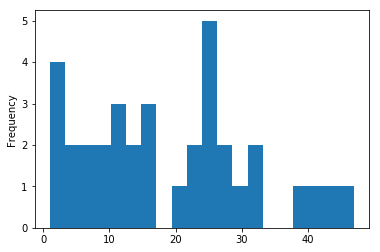

In [15]:
venue_counts_df['All'].iloc[:-1].plot(kind='hist', bins=20)

In [16]:
venue_counts_df['All'].iloc[:-1].describe()

count    35.000000
mean     18.942857
std      12.569671
min       1.000000
25%       9.000000
50%      16.000000
75%      26.500000
max      47.000000
Name: All, dtype: float64

Some neighborhoods have many more restaurants than others. Lets focus on the more populous neighborhoods. This will also have better data for modeling. According to the description above, just more than the top 25% of neighborhoods have 25 or more restaurants.

In [17]:
neighborhood_counts = restaurants_df['Neighborhood'].value_counts()
top_neighborhoods = neighborhood_counts[neighborhood_counts >= 25].index
top_neighborhoods

Index(['Garden District, Ryerson',
       'Harbourfront East, Union Station, Toronto Islands',
       'Central Bay Street', 'Church and Wellesley',
       'Kensington Market, Chinatown, Grange Park',
       'First Canadian Place, Underground city',
       'The Danforth West, Riverdale', 'St. James Town, Cabbagetown',
       'Stn A PO Boxes', 'Runnymede, Swansea',
       'Commerce Court, Victoria Hotel', 'Little Portugal, Trinity',
       'Richmond, Adelaide, King'],
      dtype='object')

In [18]:
top_neighborhoods_df = restaurants_df.loc[restaurants_df['Neighborhood'].isin(top_neighborhoods), :]
top_neighborhoods_venue_counts_df = pd.crosstab(
    top_neighborhoods_df['Neighborhood'],
    top_neighborhoods_df['category'],
    margins=True
)
top_neighborhoods_venue_counts_df

category                                           American  Asian  Bakery  \
Neighborhood                                                                 
Central Bay Street                                        0      0       0   
Church and Wellesley                                      1      0       0   
Commerce Court, Victoria Hotel                            1      0       1   
First Canadian Place, Underground city                    2      2       0   
Garden District, Ryerson                                  1      0       1   
Harbourfront East, Union Station, Toronto Islands         0      0       1   
Kensington Market, Chinatown, Grange Park                 0      0       3   
Little Portugal, Trinity                                  0      2       0   
Richmond, Adelaide, King                                  1      1       1   
Runnymede, Swansea                                        0      0       0   
St. James Town, Cabbagetown                               1      0       2   
Stn A PO Boxes                                            0      0       2   
The Danforth West, Riverdale                              1      0       1   
All                                                       8      5      12   

category                                           Bar  Beer Bar  Breakfast  \
Neighborhood                                                                  
Central Bay Street                                   1         0          0   
Church and Wellesley                                 0         1          1   
Commerce Court, Victoria Hotel                       0         1          2   
First Canadian Place, Underground city               3         0          0   
Garden District, Ryerson                             0         0          0   
Harbourfront East, Union Station, Toronto Islands    2         0          0   
Kensington Market, Chinatown, Grange Park            2         0          1   
Little Portugal, Trinity                             4         0          0   
Richmond, Adelaide, King                             0         0          1   
Runnymede, Swansea                                   1         0          0   
St. James Town, Cabbagetown                          0         0          1   
Stn A PO Boxes                                       0         2          1   
The Danforth West, Riverdale                         0         0          0   
All                                                 13         4          7   

category                                           Bubble Tea  Burgers  \
Neighborhood                                                             
Central Bay Street                                          1        2   
Church and Wellesley                                        1        2   
Commerce Court, Victoria Hotel                              0        0   
First Canadian Place, Underground city                      0        2   
Garden District, Ryerson                                    2        1   
Harbourfront East, Union Station, Toronto Islands           1        0   
Kensington Market, Chinatown, Grange Park                   0        0   
Little Portugal, Trinity                                    0        0   
Richmond, Adelaide, King                                    0        0   
Runnymede, Swansea                                          0        0   
St. James Town, Cabbagetown                                 0        0   
Stn A PO Boxes                                              0        0   
The Danforth West, Riverdale                                1        0   
All                                                         6        7   

category                                           Burritos  Café  Chinese  \
Neighborhood                                                                 
Central Bay Street                                        0     4        0   
Church and Wellesley                                      1     1  

Having eliminated the less populous neighborhoods, let's look at the categories of venues. We will throw away from analysis the less popular categories, because we don't have enough data to determine whether or not it will be popular in a particular neighborhood.

count    42.000000
mean      9.928571
std       9.991198
min       3.000000
25%       5.000000
50%       7.000000
75%       9.000000
max      58.000000
Name: All, dtype: float64

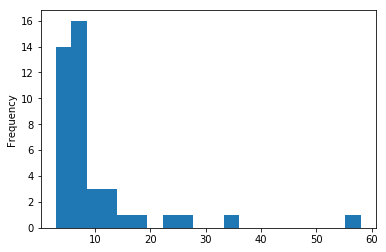

In [19]:
category_counts = top_neighborhoods_venue_counts_df.loc['All', :].iloc[:-1]
category_counts.plot(kind='hist', bins=20)
category_counts.describe()

How many neighborhoods do we have?

In [20]:
top_neighborhoods_venue_counts_df.shape

(14, 43)

Let's again consider only the top quarter of the categories. This means, according to the quartiles above, those categories with 10 or more restaurants in the top neighborhoods.


In [21]:
category_counts[category_counts >= 10]

category
Bakery         12
Bar            13
Café           35
Coffee Shop    58
Greek          11
Italian        24
Japanese       19
Pizza          14
Restaurant     26
Sushi          12
Name: All, dtype: int64

In [22]:
top_categories = category_counts[category_counts >= 10].index

In [23]:
top_neighborhoods_top_categories_df = top_neighborhoods_df.loc[top_neighborhoods_df['category'].isin(top_categories), :]
top_neighborhoods_top_categories_df

Postal Code           Borough  \
1           M5W  Downtown Toronto   
2           M5X  Downtown Toronto   
3           M4K      East Toronto   
4           M4K      East Toronto   
7           M5W  Downtown Toronto   
8           M5W  Downtown Toronto   
12          M5J  Downtown Toronto   
14          M5G  Downtown Toronto   
17          M5W  Downtown Toronto   
19          M5W  Downtown Toronto   
20          M5B  Downtown Toronto   
22          M5J  Downtown Toronto   
23          M4K      East Toronto   
24          M4X  Downtown Toronto   
25          M5T  Downtown Toronto   
26          M4X  Downtown Toronto   
27          M5B  Downtown Toronto   
29          M6S      West Toronto   
30          M5J  Downtown Toronto   
31          M5G  Downtown Toronto   
32          M6J      West Toronto   
34          M6S      West Toronto   
35          M5X  Downtown Toronto   
36          M4Y  Downtown Toronto   
37          M5T  Downtown Toronto   
43          M6J      West Toronto   
45          M6S      West Toronto   
46          M6S      West Toronto   
49          M5G  Downtown Toronto   
51          M5B  Downtown Toronto   
54          M4X  Downtown Toronto   
55          M4K      East Toronto   
56          M5T  Downtown Toronto   
58          M5J  Downtown Toronto   
59          M5G  Downtown Toronto   
61          M5X  Downtown Toronto   
63          M5B  Downtown Toronto   
64          M4X  Downtown Toronto   
66          M5T  Downtown Toronto   
67          M5L  Downtown Toronto   
69          M5T  Downtown Toronto   
72          M5L  Downtown Toronto   
73          M5H  Downtown Toronto   
74          M6S      West Toronto   
76          M5W  Downtown Toronto   
77          M5L  Downtown Toronto   
79          M4Y  Downtown Toronto   
82          M5L  Downtown Toronto   
84          M5B  Downtown Toronto   
85          M5X  Downtown Toronto   
86          M6J      West Toronto   
87          M5J  Downtown Toronto   
89          M5B  Downtown Toronto   
91          M5G  Downtown Toronto   
92          M5J  Downtown Toronto   
95          M5G  Downtown Toronto   
96          M5T  Downtown Toronto   
98          M5J  Downtown Toronto   
100         M5H  Downtown Toronto   
165         M5H  Downtown Toronto   
166         M5G  Downtown Toronto   
167         M4Y  Downtown Toronto   
168         M4Y  Downtown Toronto   
169         M6S      West Toronto   
172         M6S      West Toronto   
173         M4Y  Downtown Toronto   
177         M4Y  Downtown Toronto   
180         M5J  Downtown Toronto   
181         M5H  Downtown Toronto   
182         M4Y  Downtown Toronto   
183         M5X  Downtown Toronto   
184         M5L  Downtown Toronto   
186         M4X  Downtown Toronto   
187         M5H  Downtown Toronto   
188         M5B  Downtown Toronto   
189         M4Y  Downtown Toronto   
190         M5X  Downtown Toronto   
193         M6S      West Toronto   
194         M5W  Downtown Toronto   
195         M6J      West Toronto   
196         M5L  Downtown Toronto   
197         M5X  Downtown Toronto   
198         M4Y  Downtown Toronto   
199         M5J  Downtown Toronto   
200         M4Y  Downtown Toronto   
202         M5G  Downtown Toronto   
205         M5W  Downtown Toronto   
209         M5B  Downtown Toronto   
210         M4X  Downtown Toronto   
211         M5J  Downtown Toronto   
213         M6J      West Toronto   
216         M4X  Downtown Toronto   
218         M4K      East Toronto   
219         M5B  Downtown Toronto   
220         M5J  Downtown Toronto   
222         M6J      West Toronto   
223         M5J  Downtown Toronto   
224         M5T  Downtown Toronto   
228         M4X  Downtown Toronto   
230         M4K      East Toronto   
233         M5W  Downtown Toronto   
234         M4X  Downtown Toronto   
235         M5T  Downtown Toronto   
238         M5W  Downtown Toronto   
239         M5L  Downtown Toronto   
240         M5T  Downtown Toronto   
243         M5H  Downtown Toronto   
244     

In [24]:
top_neighborhoods_top_categories_venue_counts_df = pd.crosstab(
    top_neighborhoods_top_categories_df['Neighborhood'],
    top_neighborhoods_top_categories_df['category'],
    margins=True
)
top_neighborhoods_top_categories_venue_counts_df

category                                           Bakery  Bar  Café  \
Neighborhood                                                           
Central Bay Street                                      0    1     4   
Church and Wellesley                                    0    0     1   
Commerce Court, Victoria Hotel                          1    0     4   
First Canadian Place, Underground city                  0    3     2   
Garden District, Ryerson                                1    0     4   
Harbourfront East, Union Station, Toronto Islands       1    2     4   
Kensington Market, Chinatown, Grange Park               3    2     5   
Little Portugal, Trinity                                0    4     2   
Richmond, Adelaide, King                                1    0     2   
Runnymede, Swansea                                      0    1     3   
St. James Town, Cabbagetown                             2    0     2   
Stn A PO Boxes                                          2    0     1   
The Danforth West, Riverdale                            1    0     1   
All                                                    12   13    35   

category                                           Coffee Shop  Greek  \
Neighborhood                                                            
Central Bay Street                                          10      0   
Church and Wellesley                                         4      0   
Commerce Court, Victoria Hotel                               5      0   
First Canadian Place, Underground city                       3      1   
Garden District, Ryerson                                     7      1   
Harbourfront East, Union Station, Toronto Islands           10      0   
Kensington Market, Chinatown, Grange Park                    4      0   
Little Portugal, Trinity                                     1      1   
Richmond, Adelaide, King                                     3      0   
Runnymede, Swansea                                           3      0   
St. James Town, Cabbagetown                                  3      0   
Stn A PO Boxes                                               2      0   
The Danforth West, Riverdale                                 3      8   
All                                                         58     11   

category                                           Italian  Japanese  Pizza  \
Neighborhood                                                                  
Central Bay Street                                       2         2      0   
Church and Wellesley                                     1         5      1   
Commerce Court, Victoria Hotel                           0         3      0   
First Canadian Place, Underground city                   2         0      1   
Garden District, Ryerson                                 2         3      1   
Harbourfront East, Union Station, Toronto Islands        3         1      2   
Kensington Market, Chinatown, Grange Park                1         1      1   
Little Portugal, Trinity                                 1         1      1   
Richmond, Adelaide, King                                 0         1      1   
Runnymede, Swansea                                       2         0      3   
St. James Town, Cabbagetown                              2         1      2   
Stn A PO Boxes                                           5         0      0   
The Danforth West, Riverdale                             3         1      1   
All                                                     24        19     14   

category                                           Restaurant  Sushi  All  
Neighborhood                                                               
Central Bay Street                                          1      1   21  
Church and Wellesley                                        3      5   20  
Commerce Court, Victoria Hotel                              2      0   15  
First Canadian Place, Underground

This is much more manageable! Now since some neighborhoods have more restaurants than others (even after we threw out the least popular neighborhoods and the least popular categories), let us normalize the counts by the number of restaurants per neighborhood. This will give us, for each neighborhood, the relative frequency of each type of restaurant. From there, we can start finding restaurant opportunities.

In [25]:
relative_df = top_neighborhoods_top_categories_venue_counts_df.divide(top_neighborhoods_top_categories_venue_counts_df.loc[:, 'All'], axis=0)
relative_df

category                                             Bakery       Bar  \
Neighborhood                                                            
Central Bay Street                                 0.000000  0.047619   
Church and Wellesley                               0.000000  0.000000   
Commerce Court, Victoria Hotel                     0.066667  0.000000   
First Canadian Place, Underground city             0.000000  0.200000   
Garden District, Ryerson                           0.045455  0.000000   
Harbourfront East, Union Station, Toronto Islands  0.035714  0.071429   
Kensington Market, Chinatown, Grange Park          0.176471  0.117647   
Little Portugal, Trinity                           0.000000  0.285714   
Richmond, Adelaide, King                           0.090909  0.000000   
Runnymede, Swansea                                 0.000000  0.066667   
St. James Town, Cabbagetown                        0.133333  0.000000   
Stn A PO Boxes                                     0.166667  0.000000   
The Danforth West, Riverdale                       0.052632  0.000000   
All                                                0.053571  0.058036   

category                                               Café  Coffee Shop  \
Neighborhood                                                               
Central Bay Street                                 0.190476     0.476190   
Church and Wellesley                               0.050000     0.200000   
Commerce Court, Victoria Hotel                     0.266667     0.333333   
First Canadian Place, Underground city             0.133333     0.200000   
Garden District, Ryerson                           0.181818     0.318182   
Harbourfront East, Union Station, Toronto Islands  0.142857     0.357143   
Kensington Market, Chinatown, Grange Park          0.294118     0.235294   
Little Portugal, Trinity                           0.142857     0.071429   
Richmond, Adelaide, King                           0.181818     0.272727   
Runnymede, Swansea                                 0.200000     0.200000   
St. James Town, Cabbagetown                        0.133333     0.200000   
Stn A PO Boxes                                     0.083333     0.166667   
The Danforth West, Riverdale                       0.052632     0.157895   
All                                                0.156250     0.258929   

category                                              Greek   Italian  \
Neighborhood                                                            
Central Bay Street                                 0.000000  0.095238   
Church and Wellesley                               0.000000  0.050000   
Commerce Court, Victoria Hotel                     0.000000  0.000000   
First Canadian Place, Underground city             0.066667  0.133333   
Garden District, Ryerson                           0.045455  0.090909   
Harbourfront East, Union Station, Toronto Islands  0.000000  0.107143   
Kensington Market, Chinatown, Grange Park          0.000000  0.058824   
Little Portugal, Trinity                           0.071429  0.071429   
Richmond, Adelaide, King                           0.000000  0.000000   
Runnymede, Swansea                                 0.000000  0.133333   
St. James Town, Cabbagetown                        0.000000  0.133333   
Stn A PO Boxes                                     0.000000  0.416667   
The Danforth West, Riverdale                       0.421053  0.157895   
All                                                0.049107  0.107143   

category                                           Japanese     Pizza  \
Neighborhood                                                            
Central Bay Street                                 0.095238  0.000000   
Church and Wellesley                               0.250000  0.050000   
Commerce Court, Victoria Hotel                     0.200000  0.000000   
First Canadian Place, Underground city             0.000000  0.066667   
Garden 

We now convert the relative proportions to percentiles. The categories with low percentiles are opportunities to open new restaurants. There are two reasons for this logic:

1. We have already selected the most popular kinds of cuisines and the most popular neighborhoods within the entire city of Toronto. Therefore, for every combination of (Neighborhood, Category) in this final table, there is probably at least some demand for that kind of restaurant in that neighborhood.
2. We have normalized the counts by the total number of restaurants in each neighborhood. Therefore, we identify the cuisine categories that are _relatively_ uncommon in that particular neighborhood. So even a popular neighborhood could have opportunity for a different kind of restaurant.


In [26]:
pct_df = relative_df.rank(axis=0, pct=True)
pct_df

category                                             Bakery       Bar  \
Neighborhood                                                            
Central Bay Street                                 0.214286  0.571429   
Church and Wellesley                               0.214286  0.285714   
Commerce Court, Victoria Hotel                     0.714286  0.285714   
First Canadian Place, Underground city             0.214286  0.928571   
Garden District, Ryerson                           0.500000  0.285714   
Harbourfront East, Union Station, Toronto Islands  0.428571  0.785714   
Kensington Market, Chinatown, Grange Park          1.000000  0.857143   
Little Portugal, Trinity                           0.214286  1.000000   
Richmond, Adelaide, King                           0.785714  0.285714   
Runnymede, Swansea                                 0.214286  0.714286   
St. James Town, Cabbagetown                        0.857143  0.285714   
Stn A PO Boxes                                     0.928571  0.285714   
The Danforth West, Riverdale                       0.571429  0.285714   
All                                                0.642857  0.642857   

category                                               Café  Coffee Shop  \
Neighborhood                                                               
Central Bay Street                                 0.785714     1.000000   
Church and Wellesley                               0.071429     0.392857   
Commerce Court, Victoria Hotel                     0.928571     0.857143   
First Canadian Place, Underground city             0.321429     0.392857   
Garden District, Ryerson                           0.678571     0.785714   
Harbourfront East, Union Station, Toronto Islands  0.464286     0.928571   
Kensington Market, Chinatown, Grange Park          1.000000     0.571429   
Little Portugal, Trinity                           0.464286     0.071429   
Richmond, Adelaide, King                           0.678571     0.714286   
Runnymede, Swansea                                 0.857143     0.392857   
St. James Town, Cabbagetown                        0.321429     0.392857   
Stn A PO Boxes                                     0.214286     0.214286   
The Danforth West, Riverdale                       0.142857     0.142857   
All                                                0.571429     0.642857   

category                                              Greek   Italian  \
Neighborhood                                                            
Central Bay Street                                 0.357143  0.500000   
Church and Wellesley                               0.357143  0.214286   
Commerce Court, Victoria Hotel                     0.357143  0.107143   
First Canadian Place, Underground city             0.857143  0.785714   
Garden District, Ryerson                           0.714286  0.428571   
Harbourfront East, Union Station, Toronto Islands  0.357143  0.607143   
Kensington Market, Chinatown, Grange Park          0.357143  0.285714   
Little Portugal, Trinity                           0.928571  0.357143   
Richmond, Adelaide, King                           0.357143  0.107143   
Runnymede, Swansea                                 0.357143  0.785714   
St. James Town, Cabbagetown                        0.357143  0.785714   
Stn A PO Boxes                                     0.357143  1.000000   
The Danforth West, Riverdale                       1.000000  0.928571   
All                                                0.785714  0.607143   

category                                           Japanese     Pizza  \
Neighborhood                                                            
Central Bay Street                                 0.785714  0.142857   
Church and Wellesley                               1.000000  0.357143   
Commerce Court, Victoria Hotel                     0.928571  0.142857   
First Canadian Place, Underground city             0.142857  0.642857   
Garden 

Let us consider, for each cusiine category, the neighborhoods in the bottom 20% for that cuisine. Those are neighborhoods where we could open a new restaurant of that type with little competition.

Therefore, we recommend opening the following types of restaurants in the following neighborhoods:

In [27]:
pct_long_df = pct_df.reset_index().melt(id_vars=['Neighborhood'])
pct_long_df = pct_long_df[pct_long_df.value < 0.2]
recommendations_df = pct_long_df.sort_values(['Neighborhood', 'category', 'value'])
recommendations_df

Neighborhood     category     value
98                          Central Bay Street        Pizza  0.142857
112                         Central Bay Street   Restaurant  0.142857
29                        Church and Wellesley         Café  0.071429
72              Commerce Court, Victoria Hotel      Italian  0.107143
100             Commerce Court, Victoria Hotel        Pizza  0.142857
87      First Canadian Place, Underground city     Japanese  0.142857
118  Kensington Market, Chinatown, Grange Park   Restaurant  0.071429
49                    Little Portugal, Trinity  Coffee Shop  0.071429
78                    Richmond, Adelaide, King      Italian  0.107143
93                          Runnymede, Swansea     Japanese  0.142857
95                              Stn A PO Boxes     Japanese  0.142857
109                             Stn A PO Boxes        Pizza  0.142857
40                The Danforth West, Riverdale         Café  0.142857
54                The Danforth West, Riverdale  Coffee Shop  0.142857

For the mapping below, we need a color for each category in the recommendation and another one for "Other."

In [28]:
N_CATEGORIES = recommendations_df.category.nunique() + 1

In [29]:
category_to_code = {c: i + 1 for i, c in enumerate(recommendations_df.category.unique())}

## Map of Competitors

We illustrate the _relative_ lack of restaurants of these types by plotting the venues on a map:

In [30]:
competitors_df = top_neighborhoods_top_categories_df.loc[top_neighborhoods_top_categories_df.Neighborhood.isin(recommendations_df.Neighborhood), :]
competitors_df

Postal Code           Borough                               Neighborhood  \
1           M5W  Downtown Toronto                             Stn A PO Boxes   
2           M5X  Downtown Toronto     First Canadian Place, Underground city   
3           M4K      East Toronto               The Danforth West, Riverdale   
4           M4K      East Toronto               The Danforth West, Riverdale   
7           M5W  Downtown Toronto                             Stn A PO Boxes   
8           M5W  Downtown Toronto                             Stn A PO Boxes   
14          M5G  Downtown Toronto                         Central Bay Street   
17          M5W  Downtown Toronto                             Stn A PO Boxes   
19          M5W  Downtown Toronto                             Stn A PO Boxes   
23          M4K      East Toronto               The Danforth West, Riverdale   
25          M5T  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
29          M6S      West Toronto                         Runnymede, Swansea   
31          M5G  Downtown Toronto                         Central Bay Street   
32          M6J      West Toronto                   Little Portugal, Trinity   
34          M6S      West Toronto                         Runnymede, Swansea   
35          M5X  Downtown Toronto     First Canadian Place, Underground city   
36          M4Y  Downtown Toronto                       Church and Wellesley   
37          M5T  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
43          M6J      West Toronto                   Little Portugal, Trinity   
45          M6S      West Toronto                         Runnymede, Swansea   
46          M6S      West Toronto                         Runnymede, Swansea   
49          M5G  Downtown Toronto                         Central Bay Street   
55          M4K      East Toronto               The Danforth West, Riverdale   
56          M5T  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
59          M5G  Downtown Toronto                         Central Bay Street   
61          M5X  Downtown Toronto     First Canadian Place, Underground city   
66          M5T  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
67          M5L  Downtown Toronto             Commerce Court, Victoria Hotel   
69          M5T  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
72          M5L  Downtown Toronto             Commerce Court, Victoria Hotel   
73          M5H  Downtown Toronto                   Richmond, Adelaide, King   
74          M6S      West Toronto                         Runnymede, Swansea   
76          M5W  Downtown Toronto                             Stn A PO Boxes   
77          M5L  Downtown Toronto             Commerce Court, Victoria Hotel   
79          M4Y  Downtown Toronto                       Church and Wellesley   
82          M5L  Downtown Toronto             Commerce Court, Victoria Hotel   
85          M5X  Downtown Toronto     First Canadian Place, Underground city   
86          M6J      West Toronto                   Little Portugal, Trinity   
91          M5G  Downtown Toronto                         Central Bay Street   
95          M5G  Downtown Toronto                         Central Bay Street   
96          M5T  Downtown Toronto  Kensington Market, Chinatown, Grange Park   
100         M5H  Downtown Toronto                   Richmond, Adelaide, King   
165         M5H  Downtown Toronto                   Richmond, Adelaide, King   
166         M5G  Downtown Toronto                         Central Bay Street   
167         M4Y  Downtown Toronto                       Church and Wellesley   
168         M4Y  Downtown Toronto                       Church and Wellesley   
169         M6S      West Toronto                         Runnymede, Swansea   
172         M6S      West Toronto                         Runnymede, Swansea   
173         M4Y  Downtown Toronto                       Church and Wellesley   
177 

In [31]:
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

We draw a map for each neighborhood in which we propose to open a business. We have color coded by the category. If a dot is FILLED, then this is a competitor for the type of restaurant we want to open in this neighborhood. If the dot is EMPTY, then this restaurant is NOT a competitor--it serves a different kind of cuisine.

In [32]:
from IPython.display import display
def plot_competitors(competitors_df):
    center_lat = 0.5 * (competitors_df['venue.location.lat'].min() + competitors_df['venue.location.lat'].max())
    center_lon = 0.5 * (competitors_df['venue.location.lng'].min() + competitors_df['venue.location.lng'].max())
    map_clusters = folium.Map(location=[center_lat, center_lon], tiles='Stamen Toner', zoom_start=15)
    
    neighborhood = competitors_df.Neighborhood.iloc[0]
    recs = list(recommendations_df.loc[recommendations_df.Neighborhood == neighborhood, 'category'].unique())
    print(f"{neighborhood} Recommendations: {recs}")

    # set color scheme for the clusters
    x = np.arange(N_CATEGORIES)
    ys = [i + x + (i*x)**2 for i in range(N_CATEGORIES)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    
    for _, row in competitors_df.iterrows():
        # Everything in a different category of restaurant is labeled "Other."
        color_code = category_to_code.get(row.category, 0)
        category = row.category if row.category in category_to_code else 'Other'
        label_string = f"{category}: {row['venue.name']}"
        fill_kwargs = {}
        if category in recs:
            fill_kwargs = {
                'fill': True,
                'fill_color': rainbow[color_code],
                'fill_opacity': 0.7
            }
            label_string = 'COMPETITOR ' + label_string

        label = folium.Popup(label_string, parse_html=True)
        folium.CircleMarker(
            [float(row['venue.location.lat']), float(row['venue.location.lng'])],
            radius=9,
            popup=label,
            color=rainbow[color_code],
            **fill_kwargs
        ).add_to(map_clusters)
    display(map_clusters)
    return map_clusters

In [33]:
competitors_df.groupby('Neighborhood').apply(plot_competitors)

Central Bay Street Recommendations: ['Pizza', 'Restaurant']


Central Bay Street Recommendations: ['Pizza', 'Restaurant']


Church and Wellesley Recommendations: ['Café']


Commerce Court, Victoria Hotel Recommendations: ['Italian', 'Pizza']


First Canadian Place, Underground city Recommendations: ['Japanese']


Kensington Market, Chinatown, Grange Park Recommendations: ['Restaurant']


Little Portugal, Trinity Recommendations: ['Coffee Shop']


Richmond, Adelaide, King Recommendations: ['Italian']


Runnymede, Swansea Recommendations: ['Japanese']


Stn A PO Boxes Recommendations: ['Japanese', 'Pizza']


The Danforth West, Riverdale Recommendations: ['Café', 'Coffee Shop']


Neighborhood
Central Bay Street                           <folium.folium.Map object at 0x7fed70ed0c18>
Church and Wellesley                         <folium.folium.Map object at 0x7fed70d2d7f0>
Commerce Court, Victoria Hotel               <folium.folium.Map object at 0x7fed70ceee10>
First Canadian Place, Underground city       <folium.folium.Map object at 0x7fed70c69438>
Kensington Market, Chinatown, Grange Park    <folium.folium.Map object at 0x7fed70c333c8>
Little Portugal, Trinity                     <folium.folium.Map object at 0x7fed70b97d68>
Richmond, Adelaide, King                     <folium.folium.Map object at 0x7fed70b5de80>
Runnymede, Swansea                           <folium.folium.Map object at 0x7fed70af5dd8>
Stn A PO Boxes                               <folium.folium.Map object at 0x7fed70afb898>
The Danforth West, Riverdale                 <folium.folium.Map object at 0x7fed70ac6048>
dtype: object